In [2]:
import sys
import warnings
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
import catboost as cat

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
%matplotlib inline

Открываем данные

In [3]:
dataset = pd.read_excel('./Данные проект 2.xlsx', index_col='date')

Мы прикинули и поняли, что бизнес метрика - деньги. В случае превышения мы теряем 3 - 2 = 1 у.е. В случае недооценки мы теряем 5 - 3 = 2 у.е. Таким образом приходим к выводу, что недооценка нам стоит дороже чем переоценка.

In [4]:
def bus_metric(y_true, y_pred):
    dif = y_pred-y_true
    dif[dif<0] = np.abs(dif[dif<0]*2)
    return dif.sum()

def bus_MSE(y_true, y_pred):
    dif = y_pred-y_true
    dif[dif<0] = np.abs(dif[dif<0]*2)
    return (dif**2).sum()

Посмотрим на исходные данные.

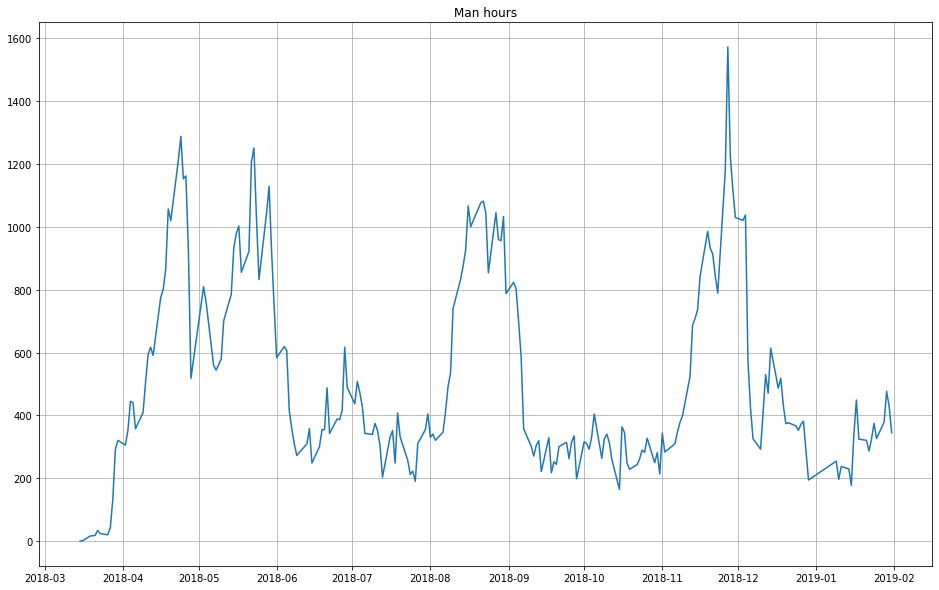

In [12]:
plt.figure(figsize=(16,10))
plt.plot(dataset['manHours'])
plt.grid()
plt.title('Man hours')
plt.show()

Предположим, что всё то, что находится между 5 и 95 квантилями - хорошие данные. Всё остальное - выбросы.

In [9]:
# Находим квантили
lower_bound = dataset['manHours'].quantile(0.05)
higher_bound = dataset['manHours'].quantile(0.95)

# Рубим квантили
new_df = dataset[(dataset['manHours'] > lower_bound.item()) & (dataset['manHours'] < higher_bound.item())]

Посмотрим, что у нас получилось

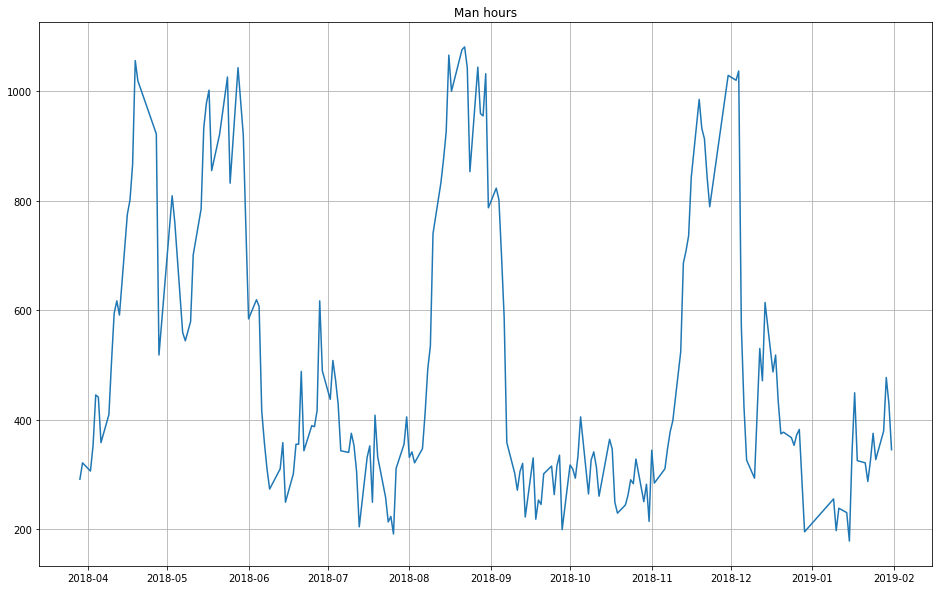

In [11]:
plt.figure(figsize=(16,10))
plt.plot(new_df['manHours'])
plt.grid()
plt.title('Man hours')
plt.show()

Попробуем воспользоваться тройным экспоненциальным сглаживанием или, что то же самое, методом Хольта-Винтерса.

In [13]:
class HoltWinters:
    
    """
    # series - исходный временной ряд
    # slen - длина сезона
    # alpha, beta, gamma - коэффициенты модели Хольта-Винтерса
    # n_preds - горизонт предсказаний
    # scaling_factor - задаёт ширину доверительного интервала по Брутлагу (обычно принимает значения от 2 до 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # инициализируем значения компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                
                
                continue
            if i >= len(self.series): # прогнозируем
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                
            
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])


            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])
                
                
                
            
            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

In [14]:
def timeseriesCVscore(x):
    # вектор ошибок
    errors = []
    
    values = data.values
    alpha, beta, gamma = x
    
    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen = 5*4, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)
    return np.mean(np.array(errors))